Набор данных, который нам предстоит использовать, имеет интересное отличие от двух предыдущих примеров. Он содержит относительно немного образцов данных: всего 506, разбитых на 404 обучающих и 102 контрольных образца. И каждый признак во входных данных (например, уровень преступности) имеет свой масштаб. Например, некоторые признаки являются пропорциями и имеют значения между 0 и 1, другие — между 1 и 12 и т. д.

УСТАНОВКА ВСЕХ НЕОБХОДИМЫХ МОДУЛЕЙ

In [ ]:
from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np

ЗАГРУЗКА ДАННЫХ

In [ ]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape) # обучающие образцы
print(test_data.shape) # контрольные образцы

print(train_targets[:20]) # цены домов

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5]


ВСЕ ДАННЫЕ ИМЕЮТ РАЗНЫЕ ПРОПОРЦИИ: НЕКОТОРЫЕ ПРИНИМАЮТ ЗНАЧЕНИЯ ОТ 0 ДО 1, А ДРУГИЕ - ОТ 1 ДО 12 И Т.Д.
ИХ НЕОБХОДИМО НОРМАЛИЗОВАТЬ

In [ ]:
mean = train_data.mean(axis=0) # вычисляется среднее значение по столбцу
train_data -= mean # из каждого элемента столбца вычитается среднее значение
std = train_data.std(axis=0) # вычисляется стандартное отклонение 
train_data /= std # каждый элемент делится на стандартное отклонение

'''
в результате получается, что признак центрируется по нулевому значению и имеет 
стандратное отклонение, равное 1
'''

test_data -= mean
test_data /= std

СОЗДАНИЕ МОДЕЛИ


In [ ]:
def build_model():
  model = Sequential()
  # чем меньше данных, тем скорее наступит переобучение
  # использование маленькой сетки - способ борьбы с переобучением
  model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(Dense(64, activation='relu'))
  # в задаче регрессии последний слой просто должен вывести предсказанное значение,
  # не изменяя его
  # если поставить функцию активации, то она будет искажать результат
  model.add(Dense(1))

  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

  return model

ПЕРЕКРЕСТНАЯ ПРОВЕРКА ПО K-БЛОКАМ

In [ ]:
'''
Если исходных данных немного, то если мы разделим их на тренировочные и проверочные,
то проверочных будет очень мало.
В таких случаях реализуется метод проверки к-блоков.
Все данные делятся на К блоков. 
Создается параллельно К моделей.
Все модели обучаются на К-1 блоках с оценкой по оставшимся блокам.
Например, если блока три:
  Прогон 1: (проверка) (обучение) (обучение) -> оценка 1 
  Прогон 2: (проверка) (проверка) (обучение) -> оценка 2
  Прогон 3: (проверка) (обучение) (проверка) -> оценка 3

Потом по всем оценкам находится среднее и принимается за оценку всей модели.
'''
def k_blocks(num_blocks, num_epochs):
  num_val_samples = len(train_data) // k # количество образцов для проверки
  all_scores = [] # массив, в который записываются оценки каждого прогона
  all_mae_histories = [] # массив, в который записывается история изменение средней ошибки за каждый прогон

  for i in range(k):
    print(f' processing fold №{i}')
    # данные и метки для проверки
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    # оставшиеся данные и метки для тренировки
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    # модель компилируется с помощью ранее созданной мной функции
    model = build_model()

    # тренировка модели
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)

    # вычисление ошибок на проверке
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

    # запись истории изменения ошибки
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

  return all_scores, all_mae_histories



all_scores, all_mae_histories = k_blocks(num_blocks=4, num_epochs=100)

 processing fold №0
 processing fold №1
 processing fold №2
 processing fold №3


ТЕПЕРЬ МОЖНО ВЫЧИСЛИТЬ СРЕДНЕЕ ЗНАЧЕНИЕ ОШИБКИ ЗА ВСЕ ПРОГОНЫ И СРЕДНЕЕ ЗНАЧЕНИЕ ОЦЕНКИ

In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

average_score = np.mean(all_scores)

ПОСТРОИМ ГРАФИК С ОЦЕНКАМИ ПРОВЕРОК ЗА ИСКЛЮЧЕНИЕМ ПЕРВЫХ 10ТИ ЗАМЕРОВ

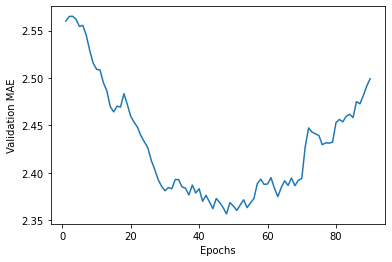

In [ ]:
# заменим каждую оценку экспоненциально скользящим средним по предыдущим оценкам, 
# чтобы получить более гладкую кривую
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
# по графику видим, что переобучение начинается после 80ой эпохи

ОБУЧЕНИЕ ОКОНЧАТЕЛЬНОЙ ВЕРСИИ МОДЕЛИ

In [ ]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

# окончательный результат 
print(f"Mean error is {round(test_mae_score * 1000)} dollars")

4/4 [==============================] - 0s 2ms/step - loss: 21.9738 - mae: 3.1633
Mean error is 3163 dollars
